# **Creación de Variables Exógenas: Factores Externos y Macroeconómicos**

Esta fase se dedica a la **ingeniería y consolidación de variables exógenas**, es decir, los **factores externos** que influyen en el comportamiento de las acciones bancarias. A partir de la especificación YAML, se generan las variables que describen:

1. **Eventos macroeconómicos y de mercado** (crisis, shocks, políticas monetarias).
2. **Contexto de volatilidad y régimen de mercado**.
3. **Factores de calendario financiero** (trimestres contables).
4. **Indicadores macroeconómicos** mensuales o trimestrales re-muestreados a diario (tipos BCE, inflación, PIB, IBEX 35).

> Las variables exógenas permiten explicar los movimientos de mercado que no derivan del propio precio: crisis globales, decisiones del BCE, shocks geopolíticos o ciclos macroeconómicos.


In [1]:
# Library imports
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

In [2]:
# Set working directory to project root
os.chdir(Path.cwd().parent)

In [3]:
# Repository imports
from src.utils.config import load_config
from src.utils.io_utils import read_csv

In [4]:
# Environment configurations
cfg = load_config("config/data.yml")

PROC_DIR = Path(".cache/processed")
EXO_DIR = cfg.io.exo_dir
EXO_DIR.mkdir(parents=True, exist_ok=True)

DATE_START = pd.Timestamp(cfg.dates.start)
DATE_END = pd.Timestamp(cfg.dates.train_end)

SYMBOLS = ["BBVA.MC", "SAN.MC"]

In [5]:
# Matplotlib configurations
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

In [6]:
# Pandas configurations
pd.set_option("display.max_columns", None)

## **Recuperación de las Series Base**
En esta parte se recuperan las series de precios de BBVA y Santander, previamente procesadas y almacenadas durante la fase de EDA. Estas series ya han sido limpiadas, depuradas y estandarizadas, por lo que representan la base sólida sobre la que se añadirán las variables exógenas.

Una vez cargadas, se revisa que las series contengan observaciones continuas entre 2000 y 2025 y que las columnas principales (precios, volumen, dividendos, etc.) estén completas.
El propósito es asegurar que no existan huecos o inconsistencias que puedan distorsionar la validación de las variables externas.

In [7]:
bbva = read_csv(PROC_DIR / "BBVA.MC_enriched.csv")
san = read_csv(PROC_DIR / "SAN.MC_enriched.csv")

In [8]:
bbva.head()  # Similar for san.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,DiffDays,IsGap,Weekday,Month,Quarter,ReturnPCT,Vol30,RegimeFlag
0,2000-01-03,13.690602,13.757854,13.594527,13.623349,4.040036,8244257,0.0,0.0,NaN,0,0,1,1,NaN,NaN,0
1,2000-01-04,13.450416,13.536882,13.219837,13.267874,3.934616,8522096,0.0,0.0,1.0,0,1,1,1,-2.609310,NaN,0
2,2000-01-05,13.142977,13.210230,12.912399,12.970044,3.846298,12159826,0.0,0.0,1.0,0,2,1,1,-2.244743,NaN,0
3,2000-01-06,12.970044,12.970044,12.970044,12.970044,3.846298,0,0.0,0.0,1.0,0,3,1,1,0.000000,NaN,0
4,2000-01-07,13.248659,13.248659,12.998866,13.133370,3.894731,62261944,0.0,0.0,1.0,0,4,1,1,1.259258,NaN,0


In [9]:
for df in [bbva, san]:  # Ensure Date is datetime and set as index
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

In [10]:
print(f"BBVA Shape: {bbva.shape} | SAN Shape: {san.shape}")

BBVA Shape: (6635, 16) | SAN Shape: (6635, 16)


In [11]:
bbva.info()  # Similar for san.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6635 entries, 2000-01-03 to 2025-10-31
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6635 non-null   float64
 1   High          6635 non-null   float64
 2   Low           6635 non-null   float64
 3   Close         6635 non-null   float64
 4   Adj Close     6635 non-null   float64
 5   Volume        6635 non-null   int64  
 6   Dividends     6635 non-null   float64
 7   Stock Splits  6635 non-null   float64
 8   DiffDays      6634 non-null   float64
 9   IsGap         6635 non-null   int64  
 10  Weekday       6635 non-null   int64  
 11  Month         6635 non-null   int64  
 12  Quarter       6635 non-null   int64  
 13  ReturnPCT     6634 non-null   float64
 14  Vol30         6605 non-null   float64
 15  RegimeFlag    6635 non-null   int64  
dtypes: float64(10), int64(6)
memory usage: 881.2 KB


Durante esta fase se depuraron las variables incluidas en el dataset enriquecido tras el EDA, conservando únicamente aquellas que aportan información relevante para la predicción a corto plazo del precio de cierre (Close). Las columnas eliminadas no mostraron una relación significativa con los movimientos de mercado ni contribuyen a mejorar el poder predictivo del modelo RNN.

* **`Adj Close`**, **`Dividends`** y **`Stock Splits`** se eliminaron por ser redundantes o constantes. El análisis se realiza *sin ajustar por dividendos*, por lo que estas variables no aportan señal útil.
* **`DiffDays`** e **`IsGap`**, que representaban los huecos de mercado por fines de semana o festivos, se descartaron porque el EDA demostró que estos intervalos no afectan de forma apreciable a los retornos ni a la volatilidad.
* **`Weekday`**, **`Month`** y **`Quarter`** reflejan efectos de calendario que, según el análisis exploratorio, no presentan estacionalidad relevante en las acciones bancarias. Los movimientos mensuales y trimestrales se explican mejor por eventos macroeconómicos ya incluidos en las variables exógenas.
* Finalmente, **`ReturnPCT`** (variación porcentual diaria) se mantiene solo para análisis y validación de correlaciones, pero no se incluye como entrada del modelo, ya que se deriva directamente de `Close` y podría generar fuga de información.

In [12]:
cols_delete = [
    "Adj Close",
    "Dividends",
    "Stock Splits",
    "DiffDays",
    "IsGap",
    "Weekday",
    "Month",
    "Quarter",
]
for df in [bbva, san]:  # Deleting unnecessary columns
    df.drop(columns=cols_delete, inplace=True)

In [13]:
bbva.info()  # Similar for san.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6635 entries, 2000-01-03 to 2025-10-31
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        6635 non-null   float64
 1   High        6635 non-null   float64
 2   Low         6635 non-null   float64
 3   Close       6635 non-null   float64
 4   Volume      6635 non-null   int64  
 5   ReturnPCT   6634 non-null   float64
 6   Vol30       6605 non-null   float64
 7   RegimeFlag  6635 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 466.5 KB


## **Construcción de la Matriz de Variables Exógenas**
El archivo de variables exógenas contiene la definición formal de todas las variables exógenas.
Cada entrada especifica su tipo (evento directo o indicador macroeconómico), su descripción, el rango de fechas (si aplica) y la fuente original de los datos o la justificación conceptual. Se realiza una separación conceptual:
* **Eventos Directos:** se transforman en banderas temporales (flags) que indican la presencia o ausencia del evento en cada fecha.
* **Indicadores Macroeconómicos:** se integran como series continuas o discretas ya interpoladas a frecuencia diaria o mensual (según la configuración).

Los eventos definidos se expanden a calendario diario para poder sincronizarlos con las series de precios.
En el caso de los indicadores macroeconómicos, se realiza la interpolación o forward-fill para asegurar continuidad temporal.
El objetivo es que todas las exógenas compartan la misma frecuencia temporal y puedan combinarse sin pérdida de información.

In [14]:
EXO_YAML = Path("config/exogenous_events.yml")
with open(EXO_YAML, "r", encoding="utf-8") as f:
    exo_cfg = yaml.safe_load(f) or {}

# Macroeconomic Series
macro_cfg = exo_cfg.get("macroeconomic_series", {}) or {}
macro_indicators = [m.get("name") for m in macro_cfg.get("indicators", [])]

# Events
events_list = exo_cfg.get("events", []) or []
event_names = [e.get("name") for e in events_list]

print("[OK] Macro:", macro_indicators)
print("[OK] Events:", event_names)

[OK] Macro: ['MACRO_ECB_Deposit_Rate', 'MACRO_Inflation_HICP_EA', 'MACRO_IBEX35']
[OK] Events: ['DotCom_Crisis', 'Spain_Credit_Boom', 'Global_Financial_Crisis', 'Euro_Sovereign_Crisis', 'Post_Crisis_Recovery', 'Brexit_2016', 'LateCycle_Weakness', 'COVID_Pandemic', 'Reopening_Recovery', 'Ukraine_War', 'ECB_Rate_Hike_Cycle', 'Profits_Buybacks_Consolidation']


### **Diseño de Variables Exógenas — Eventos Directos**
Representan sucesos discretos y bien delimitados en el tiempo, como crisis financieras, decisiones del Banco Central Europeo, elecciones, conflictos geopolíticos o pandemias.
Estos eventos suelen tener un impacto abrupto y temporal en los precios de los activos.

In [15]:
def _sanitize_col(s: str) -> str:
    """Sanitize string to be a valid column name."""
    s = re.sub(r"[^A-Za-z0-9_]+", "_", s.strip())
    s = re.sub(r"_+", "_", s).strip("_")
    return s

In [16]:
calendar = pd.DataFrame(
    {"Date": pd.date_range(DATE_START, DATE_END, freq="D")}
).set_index("Date")

In [17]:
# Create event flags
events_df = calendar.copy()
for ev in events_list:
    name = ev.get("name", "EVT")
    start = pd.to_datetime(ev.get("start", DATE_START))
    end = pd.to_datetime(ev.get("end", ev.get("start", DATE_START)))
    start = max(start, DATE_START)
    end = min(end, DATE_END)

    colname = f"EVT_{_sanitize_col(name)}"
    mask = (calendar.index >= start) & (calendar.index <= end)
    events_df[colname] = np.where(mask, 1, 0)

events_df.sample(6)

,EVT_DotCom_Crisis,EVT_Spain_Credit_Boom,EVT_Global_Financial_Crisis,EVT_Euro_Sovereign_Crisis,EVT_Post_Crisis_Recovery,EVT_Brexit_2016,EVT_LateCycle_Weakness,EVT_COVID_Pandemic,EVT_Reopening_Recovery,EVT_Ukraine_War,EVT_ECB_Rate_Hike_Cycle,EVT_Profits_Buybacks_Consolidation
Date,,,,,,,,,,,,
2012-12-21,0,0,0,1,0,0,0,0,0,0,0,0
2008-08-13,0,0,0,0,0,0,0,0,0,0,0,0
2009-12-31,0,0,0,0,0,0,0,0,0,0,0,0
2017-03-09,0,0,0,0,0,0,0,0,0,0,0,0
2006-07-26,0,1,0,0,0,0,0,0,0,0,0,0
2024-12-12,0,0,0,0,0,0,0,0,0,0,0,1


In [18]:
bbva_exo = bbva.merge(events_df, left_index=True, right_index=True, how="left")
san_exo = san.merge(events_df, left_index=True, right_index=True, how="left")

# Fill NaN event values with 0 and convert to int (if any)
for df in [bbva_exo, san_exo]:
    df[events_df.columns] = df[events_df.columns].fillna(0).astype(int)

bbva_exo.head()

,Open,High,Low,Close,Volume,ReturnPCT,Vol30,RegimeFlag,EVT_DotCom_Crisis,EVT_Spain_Credit_Boom,EVT_Global_Financial_Crisis,EVT_Euro_Sovereign_Crisis,EVT_Post_Crisis_Recovery,EVT_Brexit_2016,EVT_LateCycle_Weakness,EVT_COVID_Pandemic,EVT_Reopening_Recovery,EVT_Ukraine_War,EVT_ECB_Rate_Hike_Cycle,EVT_Profits_Buybacks_Consolidation
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03,13.690602,13.757854,13.594527,13.623349,8244257,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-04,13.450416,13.536882,13.219837,13.267874,8522096,-2.609310,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-05,13.142977,13.210230,12.912399,12.970044,12159826,-2.244743,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-06,12.970044,12.970044,12.970044,12.970044,0,0.000000,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
2000-01-07,13.248659,13.248659,12.998866,13.133370,62261944,1.259258,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0


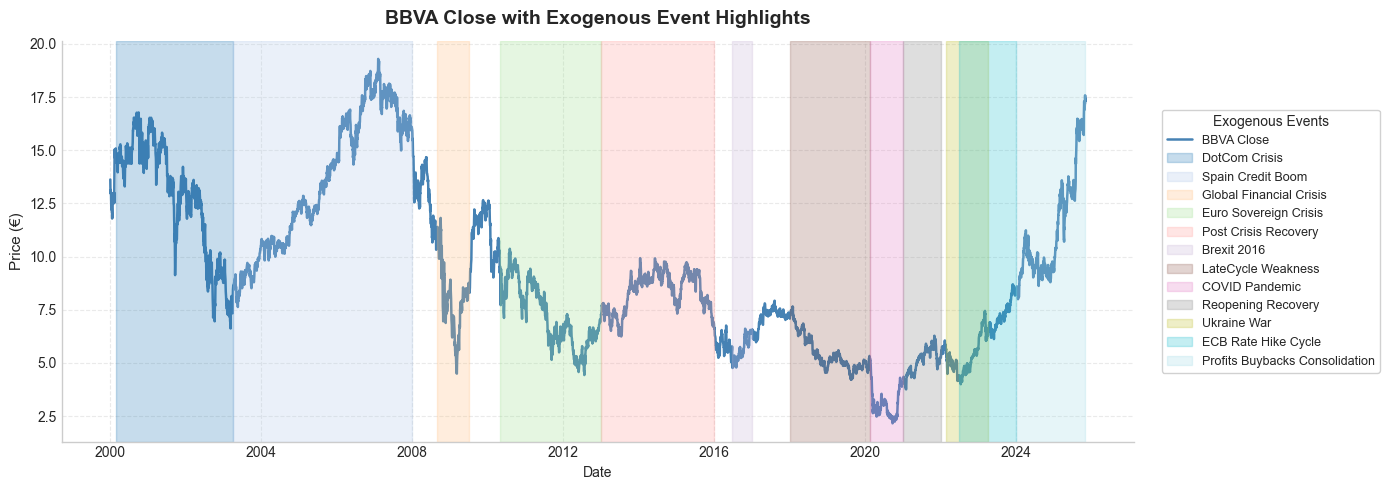

In [19]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(
    bbva.index, bbva["Close"], color="steelblue", lw=1.8, label="BBVA Close", zorder=1
)
colors = plt.colormaps["tab20"].resampled(len(events_list))

for i, ev in enumerate(events_list):
    name = ev.get("name", f"Evento_{i+1}")
    start = pd.to_datetime(ev.get("start"))
    end = pd.to_datetime(ev.get("end", ev.get("start")))

    start = max(start, bbva.index.min())
    end = min(end, bbva.index.max())
    ax.axvspan(
        start,
        end,
        color=colors(i),
        alpha=0.25,
        label=name.replace("EVT_", "").replace("_", " "),
        zorder=2,
    )

ax.set_title(
    "BBVA Close with Exogenous Event Highlights", fontsize=14, fontweight="bold", pad=12
)
ax.set_ylabel("Price (€)", fontsize=11)
ax.set_xlabel("Date", fontsize=10)
ax.grid(True, linestyle="--", alpha=0.4)

handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))

ax.legend(
    unique.values(),
    unique.keys(),
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=9,
    frameon=True,
    framealpha=0.9,
    title="Exogenous Events",
    title_fontsize=10,
)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

### **Diseño de Variables Exógenas — Indicadores Macroeconómicos**
Son series continuas o periódicas que describen el contexto económico global o regional.
Incluyen, por ejemplo, el PIB, el IPC, la tasa de desempleo, los tipos de interés oficiales o los índices de confianza.
Su influencia es más gradual y sostenida, reflejando tendencias estructurales en lugar de shocks puntuales.

In [20]:
MACRO_DIR = Path(".cache/macro")

In [21]:
# Type of Deposit BCE
ecb = pd.read_csv(MACRO_DIR / "MACRO_ECB_Deposit_Rate.csv", parse_dates=["Date"])
ecb = ecb.rename(columns={"DepositRate": "MACRO_ECB_Deposit_Rate"}).set_index("Date")

# HICP Inflation EA
hicp = pd.read_csv(MACRO_DIR / "MACRO_Inflation_HICP_EA.csv", parse_dates=["Date"])
hicp = hicp.rename(columns={"Inflation": "MACRO_Inflation_HICP_EA"}).set_index("Date")

# IBEX 35
ibex = pd.read_csv(MACRO_DIR / "MACRO_IBEX_Close.csv", parse_dates=["Date"])
ibex = ibex.rename(columns={"IBEX_Close": "MACRO_IBEX35"}).set_index("Date")

In [22]:
calendar = pd.date_range(DATE_START, DATE_END, freq="D")
macro_daily = pd.DataFrame(index=calendar)

In [23]:
# Resample and interpolate to daily frequency
macro_daily["MACRO_ECB_Deposit_Rate"] = (
    ecb.reindex(calendar).interpolate("linear").ffill().bfill()
)
macro_daily["MACRO_Inflation_HICP_EA"] = (
    hicp.reindex(calendar).interpolate("linear").ffill().bfill()
)
macro_daily["MACRO_IBEX35"] = (
    ibex.reindex(calendar).interpolate("linear").ffill().bfill()
)

In [24]:
macro_daily.head()

,MACRO_ECB_Deposit_Rate,MACRO_Inflation_HICP_EA,MACRO_IBEX35
2000-01-01,2.0,1.9,11610.000000
2000-01-02,2.0,1.9,11610.000000
2000-01-03,2.0,1.9,11610.000000
2000-01-04,2.0,1.9,11206.599609
2000-01-05,2.0,1.9,10863.099609


In [25]:
bbva_exo = bbva_exo.merge(macro_daily, left_index=True, right_index=True, how="left")
san_exo = san_exo.merge(macro_daily, left_index=True, right_index=True, how="left")

macro_cols = list(macro_daily.columns)
for df in [bbva_exo, san_exo]:
    df[macro_cols] = df[macro_cols].ffill().bfill()

In [26]:
bbva_exo.info()  # Similar for san_exo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6635 entries, 2000-01-03 to 2025-10-31
Data columns (total 23 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Open                                6635 non-null   float64
 1   High                                6635 non-null   float64
 2   Low                                 6635 non-null   float64
 3   Close                               6635 non-null   float64
 4   Volume                              6635 non-null   int64  
 5   ReturnPCT                           6634 non-null   float64
 6   Vol30                               6605 non-null   float64
 7   RegimeFlag                          6635 non-null   int64  
 8   EVT_DotCom_Crisis                   6635 non-null   int32  
 9   EVT_Spain_Credit_Boom               6635 non-null   int32  
 10  EVT_Global_Financial_Crisis         6635 non-null   int32  
 11  EVT_Euro_Sovereign_Crisis

In [27]:
bbva_exo.sample(6)

,Open,High,Low,Close,Volume,ReturnPCT,Vol30,RegimeFlag,EVT_DotCom_Crisis,EVT_Spain_Credit_Boom,EVT_Global_Financial_Crisis,EVT_Euro_Sovereign_Crisis,EVT_Post_Crisis_Recovery,EVT_Brexit_2016,EVT_LateCycle_Weakness,EVT_COVID_Pandemic,EVT_Reopening_Recovery,EVT_Ukraine_War,EVT_ECB_Rate_Hike_Cycle,EVT_Profits_Buybacks_Consolidation,MACRO_ECB_Deposit_Rate,MACRO_Inflation_HICP_EA,MACRO_IBEX35
Date,,,,,,,,,,,,,,,,,,,,,,,
2020-11-18,3.490000,3.552000,3.429000,3.511000,28293824,0.400341,5.002160,1,0,0,0,0,0,0,0,1,0,0,0,0,-0.50,-0.300000,7981.500000
2004-11-11,11.913225,11.961262,11.701861,11.797936,46534668,-0.967737,1.162206,0,0,1,0,0,0,0,0,0,0,0,0,0,1.00,2.326667,8558.500000
2003-11-07,9.693906,9.741944,9.636262,9.693906,43954289,1.000998,1.215371,0,0,1,0,0,0,0,0,0,0,0,0,0,1.00,2.046667,7267.799805
2019-07-30,4.786500,4.793500,4.622500,4.656500,31956350,-3.029991,1.247788,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.40,1.009677,8986.599609
2025-07-28,13.260000,13.375000,13.110000,13.180000,8131572,1.151194,1.588713,0,0,0,0,0,0,0,0,0,0,0,0,1,2.00,2.000000,14220.200195
2009-12-08,12.374382,12.547316,12.163019,12.244682,22233310,-1.961536,1.743820,0,0,0,0,0,0,0,0,0,0,0,0,0,0.25,0.603226,11808.900391


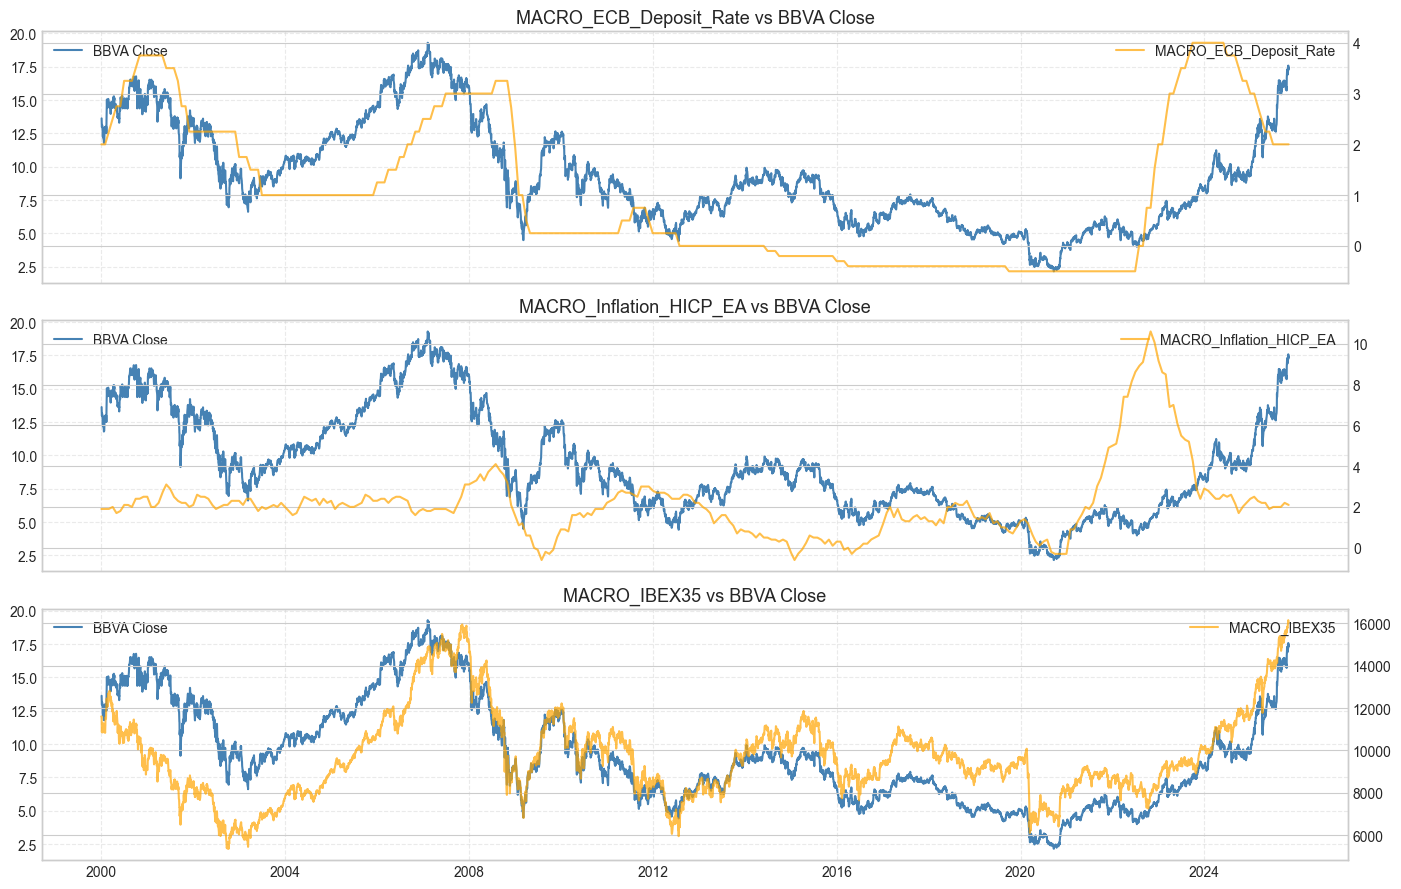

In [28]:
macro_cols = macro_daily.columns.tolist()
fig, axes = plt.subplots(
    len(macro_cols), 1, figsize=(14, 3 * len(macro_cols)), sharex=True
)
if len(macro_cols) == 1:
    axes = [axes]

for i, col in enumerate(macro_cols):
    ax1 = axes[i]
    ax1.plot(bbva["Close"], color="steelblue", label="BBVA Close")
    ax2 = ax1.twinx()
    ax2.plot(macro_daily.index, macro_daily[col], color="orange", alpha=0.7, label=col)

    ax1.set_title(f"{col} vs BBVA Close")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax1.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()